# Fit transits using jaxoplanet + tinyGP

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial
import numpyro
numpyro.set_host_device_count(2)
from numpyro import distributions as dist, infer
from numpyro_ext import distributions as distx
from jaxoplanet.orbits.transit import TransitOrbit
from jaxoplanet.orbits import keplerian
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.experimental import calc_poly_coeffs
from tinygp import kernels, GaussianProcess
import arviz as az
import corner


## Functions to compute transit LC using jaxoplanet

Jaxoplanet uses polynomial limb-darkening coefficients, but we want to use power2 limb-darkening. I asked the jaxoplanet team if it would be possible to do that (see [issue 264](https://github.com/exoplanet-dev/jaxoplanet/issues/264)), and they provided a new function to approximate any radially symmetric limb-darkening law using a polynomial (see [issue 269](https://github.com/exoplanet-dev/jaxoplanet/pull/269)). I am using that below, manually setting the order of the polynomial used. I have asked if it would be possible to add a routine to automatically compute the order needed to achieve a given precision ([issue 273](https://github.com/exoplanet-dev/jaxoplanet/issues/273)), a bit like the "fac" parameter in Batman. Noone is working on it right now as far as I'm aware, but Soichiro Hattori (a PhD student at Columbia University working with Dan Foreman-Mackey and Ruth Angus, and one of the jaxoplanet developpers) is visiting me in Oxford in the first half of September, so we could potentially work on it then.

In [35]:
@jax.jit
def get_c_alpha_from_q1_q2(q1, q2):
    # convert power2 LD params from q1, q2 to c, alpha
    sq1 = jnp.sqrt(q1)
    q2sq1 = q2 * sq1
    c = 1 - q2sq1
    alpha = jnp.log2(c/(1-sq1))
    return c, alpha


@jax.jit
def get_I_power2(c, alpha, u):
    # Evaluate the power2 limb-darkening law for parameters c and alpha at limb angle(s) u
    return 1 - c*(1-jnp.power(u,alpha))

In [36]:
POLY_DEGREE = 5 # 5 might be a bit low, but increasing this makes the whole thing quite slow
MUS = jnp.linspace(0.01, 1, 20, endpoint=True) # Array of limb-angles where the limb-darkening law is evaluated. 
# The polynomial coefficients are then obtained via a least-squares fit. 
# Once again, 20 values between mu = 0.01 and mu = 1 is probably a minimum, but increasing it makes everything slower.

In [37]:
@jax.jit
def get_transit_lc(params, t, ld = 'power2', 
                   degree = POLY_DEGREE, mus = MUS):
    # set up orbit
    orbit = TransitOrbit(
        period = params["period"],
        time_transit = params["t0"],
        impact_param = params["b"], 
        radius_ratio = params["k"],
        duration = params["duration"],
    )
    # NB: If we wanted to use a Keplerian orbit instead, we would specify rstar & ars instead of duration
    # star = keplerian.Central.from_orbital_properties(
    #     period = params["period"],
    #     semimajor = params["ars"] * params["rstar"],
    #     radius = params["rstar"]
    # )
    # orbit = keplerian.System(star).add_body(
    #     period = params["period"], 
    #     time_transit = params["t0"], 
    #     radius = params["k"] * params["rstar"],
    #     impact_param = params["b"],
    #     eccentricity = params["ecc"],
    #     omega_peri = params["w"]
    #     )    
    # estimate polynomial LD coeffs corresponding to power2 law with specified parameters
    u = params['u']
    q1, q2 = u[0], u[1] # we sample q1, q2, which range from 0 to 1
    c, alpha = get_c_alpha_from_q1_q2(q1, q2) # convert them to c, alpha
    power2_profile = get_I_power2(c, alpha, mus)
    u_poly = calc_poly_coeffs(mus, power2_profile,  
                              poly_degree = degree)
    # evaluate and return LC
    return limb_dark_light_curve(orbit, u_poly)(t) + 1.0

@jax.jit
def get_trel(params, t):
    ph1 = jnp.mod(t - params['t0'], params['period']) 
    ph2 = ph1 - params['period']
    ph3 = ph1 + params['period']
    a = jnp.array([ph1, ph2, ph3])
    i = jnp.argmin(jnp.abs(a))
    return a[i]

@jax.jit
def get_transit_model(params, X):
    t = X[0]
    trno = X[1].astype('int')
    # the full transit model includes a polynomial for the out-of-transit baseline, but it's separate for each transit
    oot_coeff = params['oot'][trno]
    trel = get_trel(params, t)
    pol = jnp.polyval(oot_coeff, trel)
    return get_transit_lc(params, t) * pol

@jax.jit
def get_oot_model(params, X):
    t = X[0]
    trno = X[1].astype('int')
    # the full transit model includes a polynomial for the out-of-transit baseline, but it's separate for each transit
    oot_coeff = params['oot'][trno]
    trel = get_trel(params, t)
    pol = jnp.polyval(oot_coeff, trel)
    return pol


In [62]:
@jax.jit
def get_gp_sample(params, X):
    t = X[0]
    kernel = kernels.quasisep.SHO(
        sigma = params["gp_sig"],
        omega = 2 * jnp.pi / params["gp_tau"], 
        quality = 1.0 / jnp.sqrt(2)
    )
    diag = jnp.square(params["wn"])
    GaussianProcess(kernel, t, diag = diag)

# Simulate some data

First let's simulate some data with white noise only

(200,)


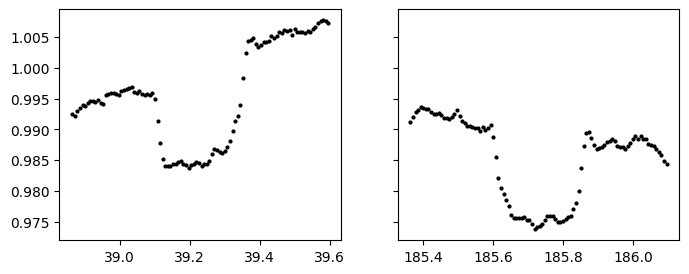

In [118]:
params_true = {
    'period': 146.5,
    'b': 0.1, 
    'k': 0.11,
    't0': 39.23, 
    'u': jnp.array([0.3, 0.5]), # made up
    'duration': 0.276,
    'oot': jnp.array([[0.02, 1.0],[-0.01,0.99]]), 
    'gp_tau': 0.1, 
    'gp_sig': 1e-3,
    'wn': 1e-4,
}
phase = jnp.linspace(-0.0025,0.0025,100)
t1 = phase * params_true['period'] + params_true['t0']
t = jnp.concatenate([t1, t1+params_true['period']])
orbit = np.floor((t - params_true['t0'] + params_true['period']/2) / params_true['period']).astype(int)
trno = jnp.digitize(orbit, bins = np.r_[orbit.min()-0.5:orbit.max()+1:1]) - 1

X = np.array([t,trno]).T
transit_model = jax.vmap(partial(get_transit_model, params_true))(X)

correlated_noise = GaussianProcess(
    kernels.quasisep.SHO(
        sigma = params_true["gp_sig"],
        omega = 2 * jnp.pi / params_true["gp_tau"], 
        quality = 1.0 / jnp.sqrt(2)
    ), t
).sample(jax.random.PRNGKey(0))
print(correlated_noise.shape)

white_noise = np.random.randn(len(t)) * params_true['wn']

y = transit_model + correlated_noise + white_noise

ntr = len(np.unique(trno))
fig, ax = plt.subplots(ncols = ntr, nrows = 1, figsize = (ntr*4, 3), sharey = True)
for j in range(ntr):
    l = trno == np.unique(trno)[j]
    ax[j].errorbar(t[l], y[l], yerr = params_true['wn'], fmt='k.', ms = 4)


## Numpyro model

Before we define our model we need to define some variables which control the priors, as well as a dictionary that controls what's fixed and what's not

In [119]:
USE_GP = True 
fixed = {
    'period': False,
    'b': False, 
    'k': False,
    't0': False, 
    'u': False,
    'duration': False,
    'oot': False,
    'gp_tau': False,
    'gp_sig': False,
    'wn': False,
}

In [120]:
PERIOD = params_true["period"]
DURATION = params_true["duration"]
NTR = max(orbit) - min(orbit) + 1
MAX_PER_OFF = 0.5 * DURATION / NTR
PRIOR_SIGMA = 0.5

In [121]:
def numpyro_model(X, y = None):

    # Sample parameters for transit model
    if fixed["period"]:
        period = numpyro.deterministic("period", params_true["period"])
    else:
        period = numpyro.sample("period", dist.TruncatedNormal(params_true['period'], 
                                                               PRIOR_SIGMA/100.0,
                                                               low = params_true['period'] - MAX_PER_OFF,
                                                               high = params_true['period'] + MAX_PER_OFF))
    if fixed["t0"]:
        t0 = numpyro.deterministic("t0", params_true["t0"])
    else:
        t0 = numpyro.sample("t0", dist.Uniform(
            params_true['t0'] - params_true['duration'], 
            params_true['t0'] + params_true['duration']
        ))
    if fixed["duration"]:
        duration = numpyro.deterministic("duration", params_true["duration"])
    else:
        duration = numpyro.sample("duration", dist.LogNormal(jnp.log(params_true['duration']), PRIOR_SIGMA/10.0))
    if fixed["k"]:
        k = numpyro.deterministic("k", params_true["k"])
    else:
        k = numpyro.sample("k", dist.Uniform(0, 1))
    if fixed["b"]:
        b = numpyro.deterministic("b", params_true["b"])
    else:
        b = numpyro.sample("b", dist.Uniform(0, 1+k))
    if fixed["u"]:
        u = numpyro.deterministic("u", params_true["u"])
    else:
        u = numpyro.sample("u", dist.Uniform(jnp.zeros(2), jnp.ones(2)))
        q1 = numpyro.deterministic("q1", u[0])
        q2 = numpyro.deterministic("q2", u[1])
        c, alpha = get_c_alpha_from_q1_q2(q1, q2)
        numpyro.deterministic("c", c)
        numpyro.deterministic("alpha", alpha)
    if fixed["oot"]:
        oot = numpyro.deterministic("oot", params_true["oot"])
    else:
        # Using normal priors for OOT coeffs isn't ideal, but I'm doing it here as a quick fix
        oot = numpyro.sample("oot", dist.Normal(params_true["oot"], PRIOR_SIGMA/10.0))
    # evaluate transit model
    tr_par = {
        'period': period,
        'b': b,
        'k': k,
        'duration': duration, 
        't0': t0, 
        'u': u,
        "oot": oot,
    }
    mf = numpyro.deterministic("mf", jax.vmap(partial(get_transit_model, tr_par))(X))
    resid = numpyro.deterministic("resid", y - mf)

    # Sample jitter and evaluate white noise
    if fixed["wn"]:
        wn = numpyro.deterministic("wn", params_true["wn"])
    else:
        wn = numpyro.sample("wn", dist.HalfNormal(PRIOR_SIGMA/10.0))
    diag = numpyro.deterministic("diag", jnp.square(wn))

    if USE_GP:
        # Sample GP HPs 
        if fixed['gp_sig']:
            gp_sig = numpyro.deterministic("gp_sig", params_true["gp_sig"])
        else:
            gp_sig = numpyro.sample("gp_sig", dist.HalfNormal(PRIOR_SIGMA/10.0))
        if fixed['gp_tau']:
            gp_tau = numpyro.deterministic("gp_tau", params_true["gp_tau"])
        else:
            gp_tau = numpyro.sample("gp_tau", dist.LogUniform(0.01, 0.5))
        # Build GP
        kernel = kernels.quasisep.SHO(
            sigma = gp_sig,
            omega = 2 * jnp.pi / gp_tau, 
            quality = 1.0 / jnp.sqrt(2)
        )
        gp = GaussianProcess(kernel, t, diag = diag)
        # Evaluate likelihood     
        numpyro.sample("like", gp.numpyro_dist(), obs=resid)
        # Evaluate predictive mean 
        if y is not None:
            numpyro.deterministic("gp_pred", gp.condition(resid, t).gp.loc)
    else:
        if y is not None:
            numpyro.deterministic("gp_pred", jnp.zeros_like(y))
        # Evaluate likelihood for white noise model
        numpyro.sample("like", dist.Normal(mf, jnp.sqrt(diag)), obs=y)    

## MCMC

In [122]:
sampler = infer.MCMC(
    infer.NUTS(numpyro_model, 
               init_strategy = infer.init_to_value(values = params_true),
               # init_strategy = infer.init_to_median(),
               dense_mass=True, 
               target_accept_prob=0.9,
              ),
    num_warmup=100,
    num_samples=1000,
    progress_bar=True,
    num_chains=2,
)

sampler.run(jax.random.PRNGKey(123), X, y=y)



  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

In [123]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()

par_names = []
keys = [p for p in params_true]
truths = {}
for name in params_true:
    par_names.append(name)
    truths[name] = params_true[name]


In [124]:
az.summary(inf_data, var_names=par_names, round_to = 5)

/Users/aigrain/miniforge3/lib/python3.10/site-packages/xarray/core/concat.py:532: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,146.49914,0.00109,146.49717,146.50117,0.00002,0.00002,2205.58530,1504.67652,1.00100
b,0.07286,0.05354,0.00001,0.16942,0.00263,0.00186,318.61583,389.01106,1.00483
k,0.11232,0.00169,0.10919,0.11548,0.00004,0.00003,1931.96129,1511.62646,1.00103
t0,39.23110,0.00083,39.22944,39.23255,0.00002,0.00001,2044.68354,1785.75009,1.00012
u[0],0.34097,0.20933,0.03185,0.71591,0.01254,0.00888,264.48397,366.98428,1.00101
u[1],0.49090,0.18425,0.13076,0.76161,0.01149,0.00813,297.59935,263.69537,1.00161
duration,0.27652,0.00170,0.27337,0.27975,0.00006,0.00004,810.41851,1423.35291,1.00033
"oot[0, 0]",0.02062,0.00111,0.01860,0.02277,0.00003,0.00002,1887.46448,1008.28558,1.00244
"oot[0, 1]",1.00016,0.00027,0.99962,1.00062,0.00001,0.00000,2034.00440,1310.36499,1.00113
"oot[1, 0]",-0.00841,0.00115,-0.01041,-0.00623,0.00003,0.00002,1678.61418,1151.56888,1.00032


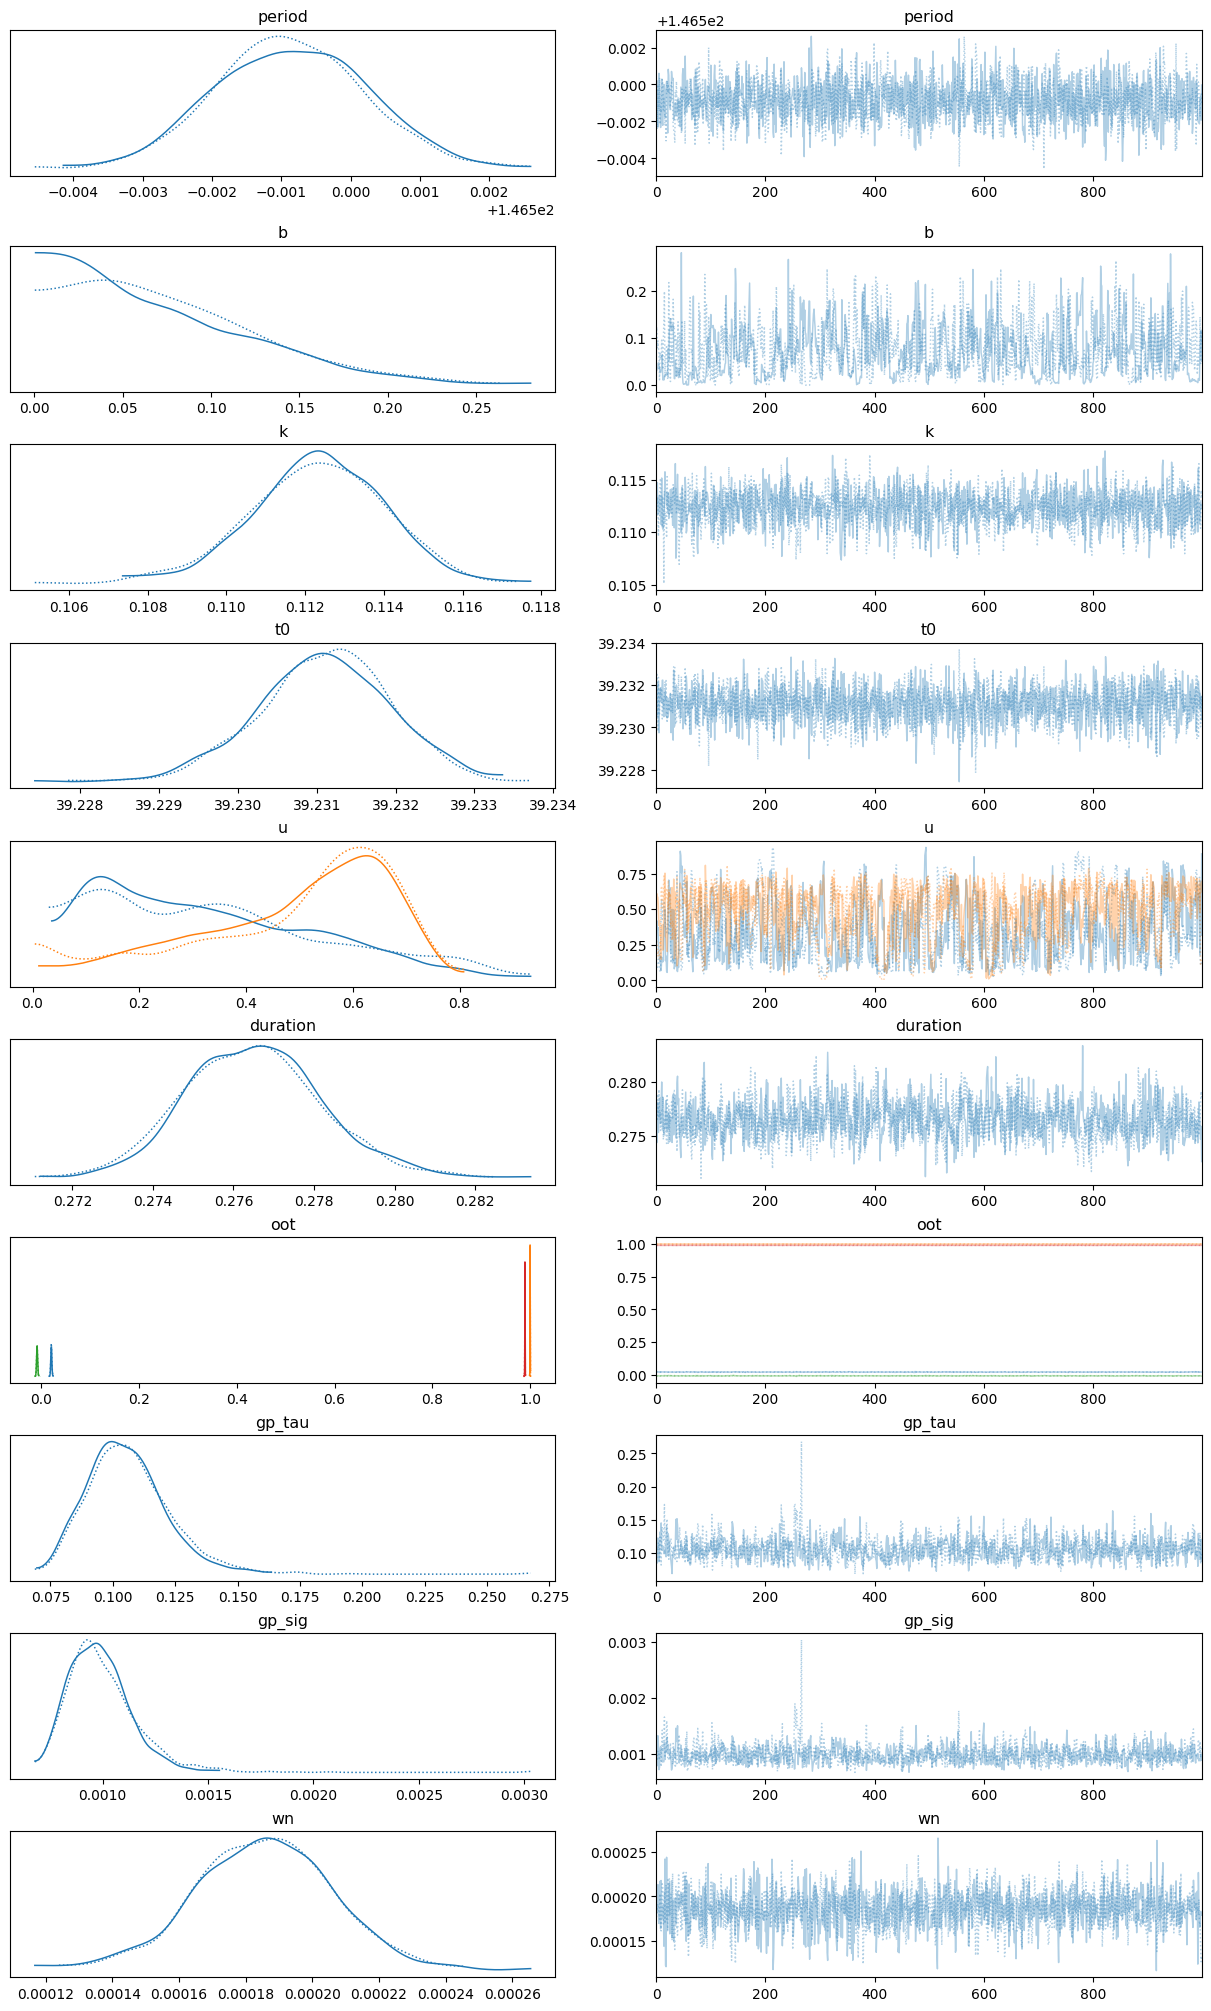

In [125]:
_ = az.plot_trace(
    inf_data,
    var_names=par_names,
    backend_kwargs={"constrained_layout": True},
)


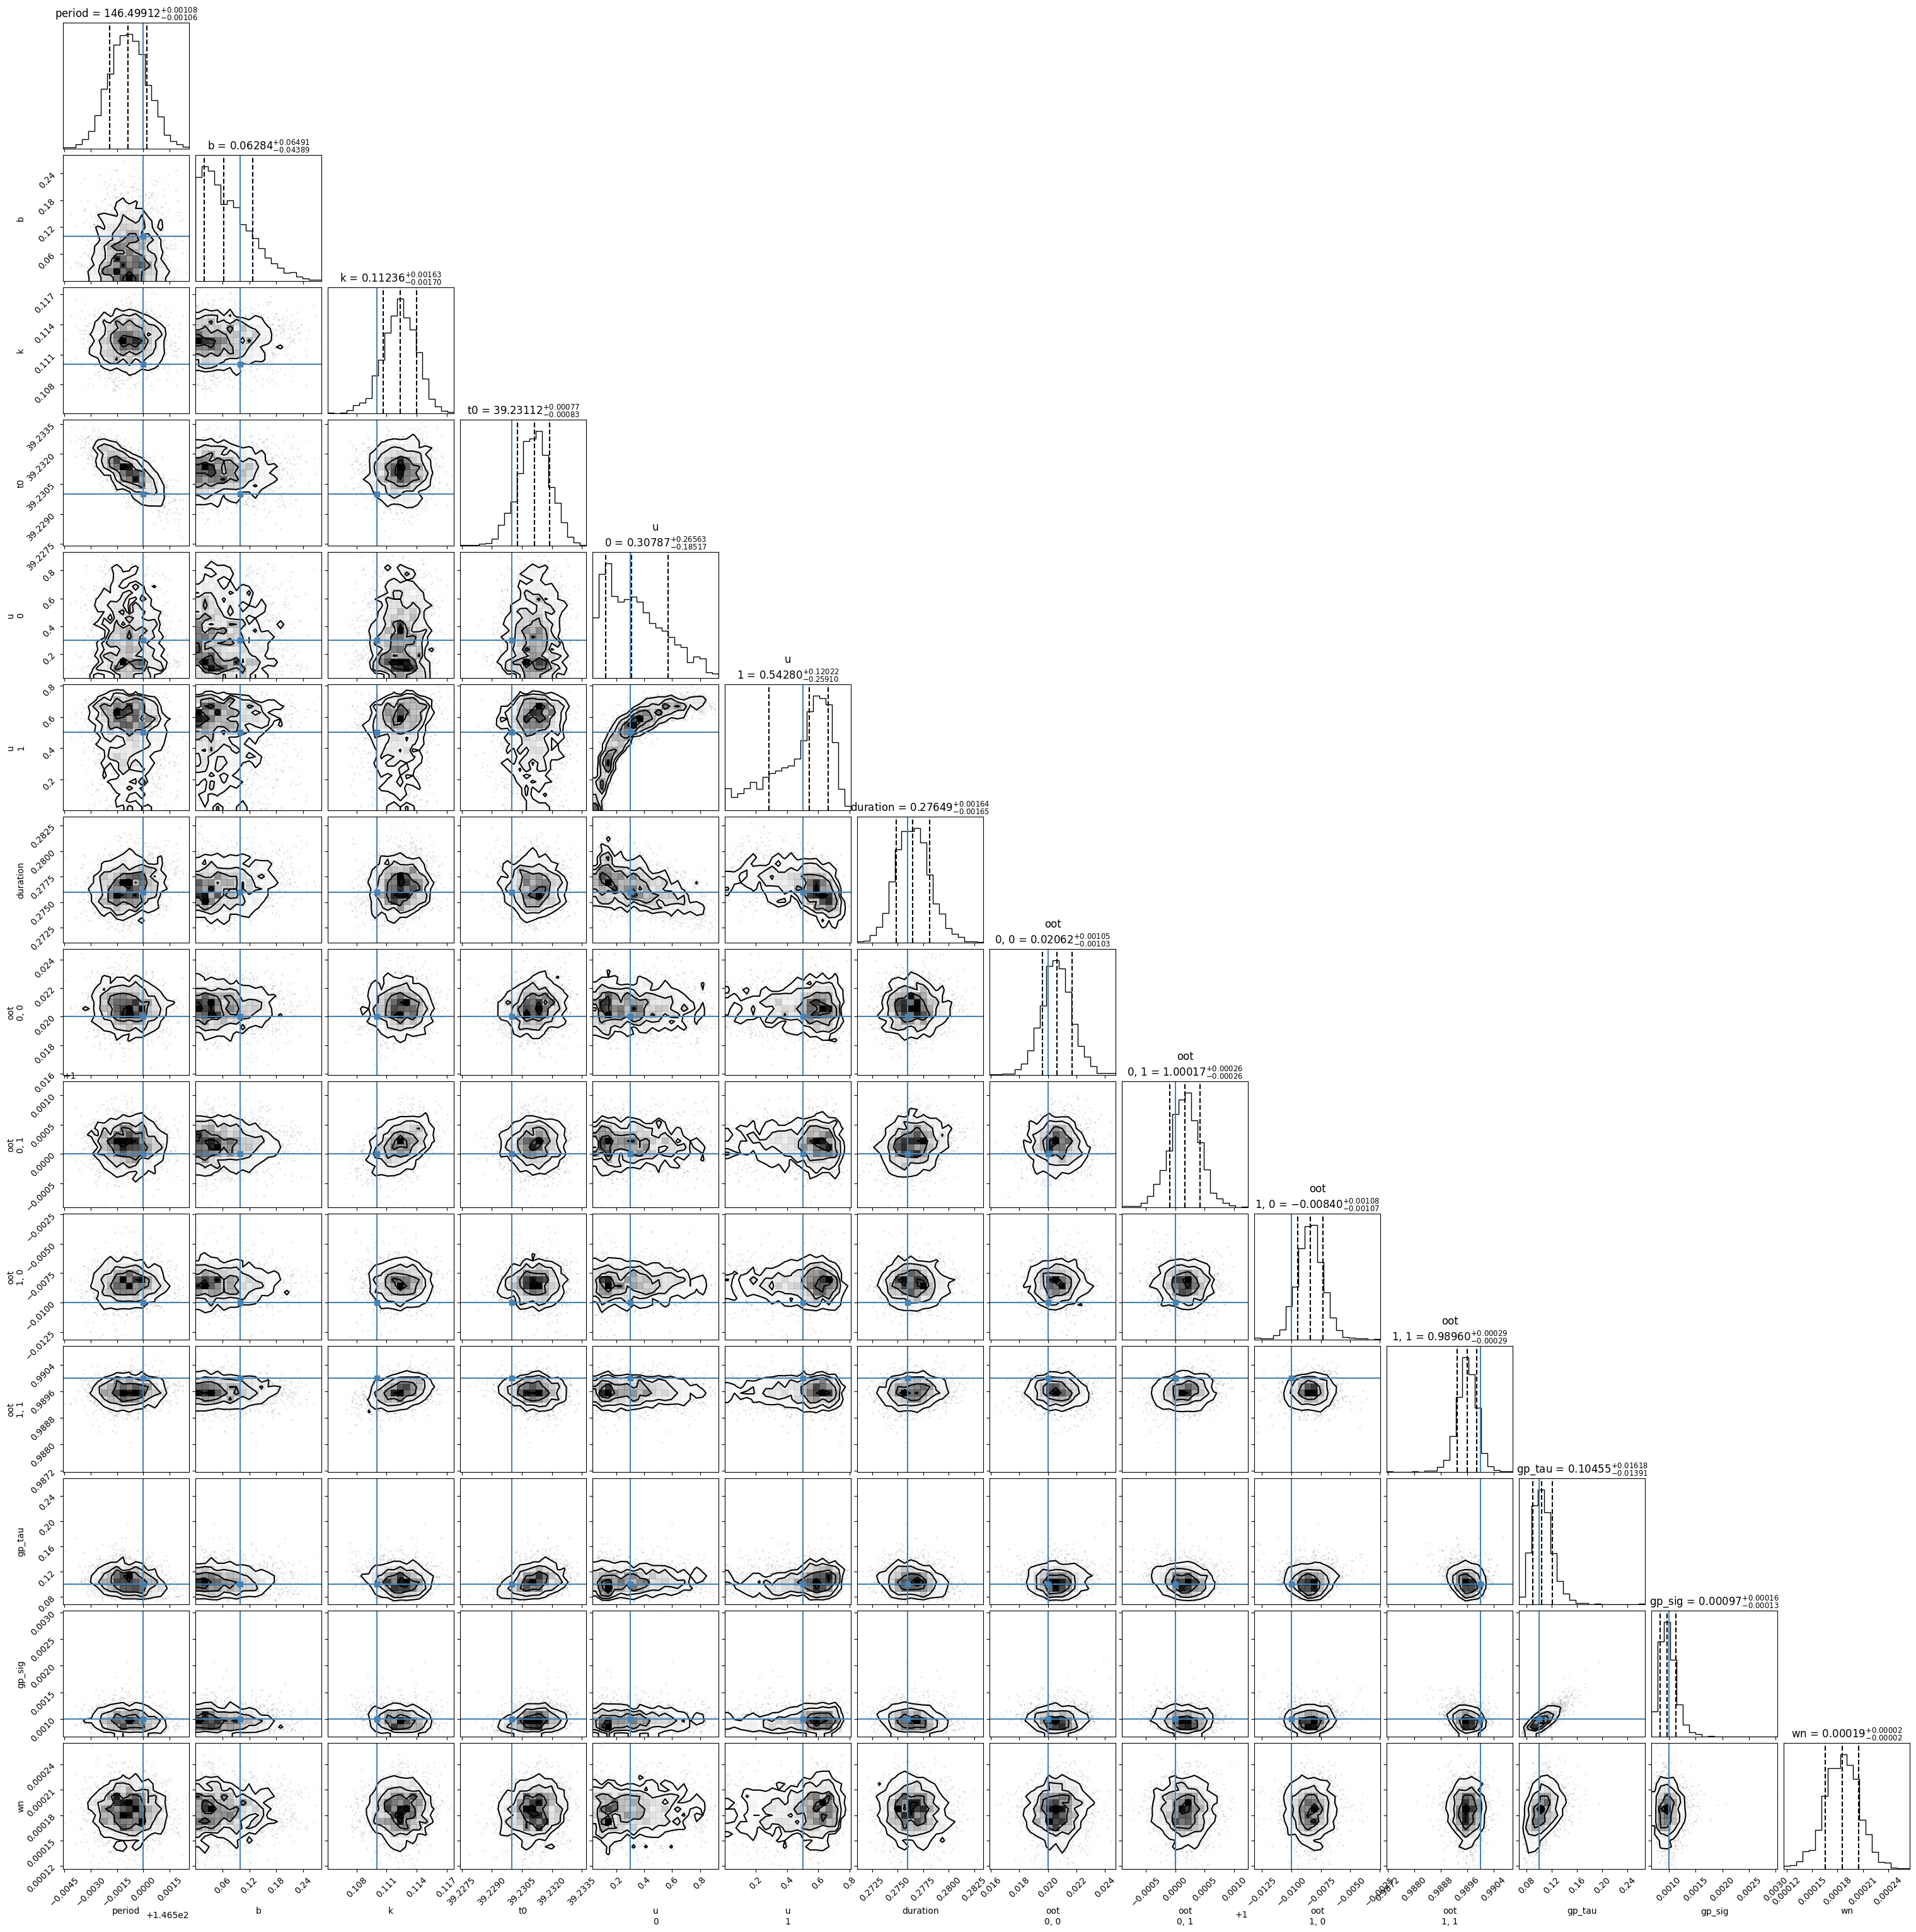

In [126]:
_ = corner.corner(
    inf_data,
    var_names=par_names,
    truths = truths,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".5f",
)


## Save chains

Uncomment the cell below to save the chains in json format

In [127]:
# _ = az.to_json(
#     inf_data, OUT_ROOT + '_chains.json',
# )

## Plot fit

In [128]:
samples = sampler.get_samples()

mfs = samples["mf"]
gps = samples["gp_pred"]

In [129]:
mf_low, mf_med, mf_high = np.percentile(mfs, [16, 50, 84], axis=0)
gp_low, gp_med, gp_high = np.percentile(gps, [16, 50, 84], axis=0)
al_low, al_med, al_high = np.percentile(mfs + gps, [16, 50, 84], axis=0)

In [130]:
orb = np.unique(trno)
ntr = len(orb)
wn_fit = np.median(samples["wn"])

First plot transits one by one with combined transit + polynmial (+GP) model overplotted

Text(0.5, 0, 'time')

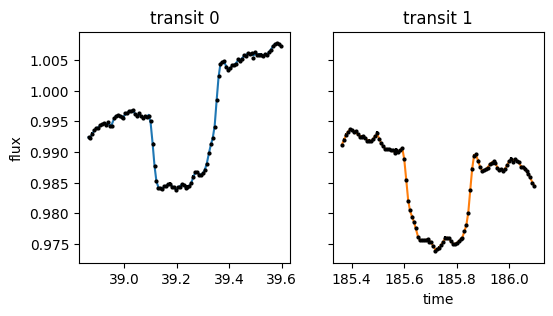

In [131]:
fig, ax = plt.subplots(ncols = ntr, nrows = 1, figsize = (ntr*3, 3), sharey = True)
for i in range(ntr):
    l = trno == orb[i]
    ax[i].errorbar(t[l], y[l], yerr = wn_fit, fmt=f'k.', ms = 4)
    ax[i].plot(t[l], al_med[l], f"C{i}")
    ax[i].fill_between(
        t[l],
        al_low[l], al_high[l], 
        alpha=0.3,
        color=f"C{i}", lw = 0
    )
    ax[i].set_title(f'transit {orb[i]}')
ax[0].set_ylabel('flux')
ax[int(ntr/2)].set_xlabel('time')

Correct baseline and plot phase-folded transit

In [132]:
# NB should really replace means with MAP estimates
t0_fit = np.mean(samples["t0"])
period_fit = np.mean(samples["period"])
print(period_fit)
oot_coeff_fit = samples["oot"].mean(axis=0)
oot_params_fit = {
    "oot": oot_coeff_fit,
    "t0": t0_fit,
    "period": period_fit,
}
oot_fit = jax.vmap(partial(get_oot_model, oot_params_fit))(X) + gp_med
tr_fit = al_med / oot_fit

y_corr = y / oot_fit

ph = np.array((t - t0_fit) % period_fit / period_fit)
ph[ph>0.5]-= 1
ph[ph<-0.5]+=1

s = np.argsort(ph)

146.49913865113368


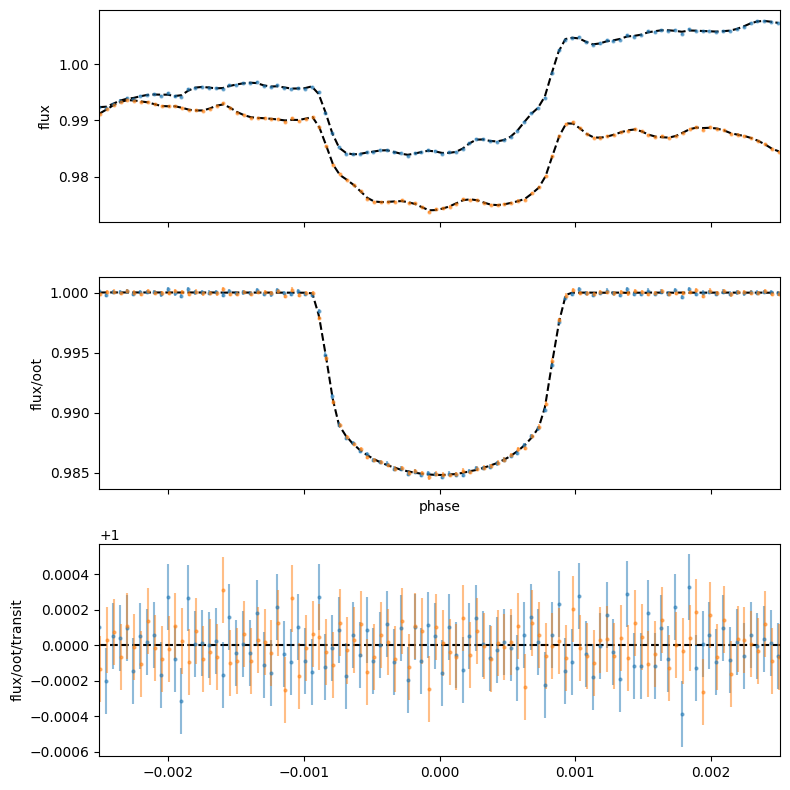

In [133]:
fig, ax = plt.subplots(ncols = 1, nrows = 3, figsize = (8,8), sharex = True)

ax[1].plot(ph[s], tr_fit[s], 'k--')
ax[2].axhline(1.0, color = 'k', ls = 'dashed')
for i in range(ntr):
    l = trno == orb[i]
    ax[0].errorbar(ph[l], y[l], yerr = wn_fit, fmt = f'C{i}.', ms = 4, alpha = 0.5)
    ax[0].plot(ph[l], al_med[l], f'k--')       
    ax[1].errorbar(ph[l], y_corr[l], yerr = wn_fit, fmt = f'C{i}.', ms = 4, alpha = 0.5)
    ax[2].errorbar(ph[l], y_corr[l]/tr_fit[l], yerr = wn_fit, fmt = f'C{i}.', ms = 4, alpha = 0.5)
ax[0].set_ylabel('flux')
ax[1].set_ylabel('flux/oot')
ax[2].set_ylabel('flux/oot/transit')
phm = np.max(abs(ph))
plt.xlim(-phm, phm)
ax[1].set_xlabel('phase')
plt.tight_layout()